# Government Policies: Social Media Analytics

<b><font color="blue" size = 3>Objective:</font></b>       
 - Determining the public response to various government policies in Galway based on <b>accessing, integrating and analysing tweets</b> from Local Media house (Newspaper or Radio station) and <b>discussions on Reddit forums</b>. 
 - In other words, the task entails creating <font color="green">structured dataset</font> that captures key information <font color="brown">from free text tweets and comments</font> and use it for analysing peoples' opinion.    
 
<b><font color="blue" size = 3>Key Tasks:</font></b>    
1. Accessing Posts and Comments from Twitter and Reddit     
2. Identifying relevant	posts    
3. Analysis/ Visualization of relevant posts    
    3.1. Gauging policy popularity with Tweet/ Retweet/ Hashtag counts    
    3.2. Policy review based on Reddit submissions and comments counts    
    3.3. <font color="brown">Sentiment Analysis</font> of Tweets and Reddit comments
4. Observations and conclusion

### Load Libraries

In [1]:
import json
import pandas as pd

### Extracting Data from Twitter & Reddit

1. **Extracting Tweets from Twitter:**    
 - Tweets are accessed using the [tweepy API](http://www.tweepy.org/) in python from Twitter accounts of local media houses and politicians.    
 - <font color="brown">Python script:</font> *"Retrieve_Twitter_Data.py"*   
 - <font color="blue">Extracted in file:</font> *"tweets.JSON"*
    
    
    
2. **Obtaining comments and submissions from Reddit discussion forum:** 
 - Submissions and comments are extracted from the *Ireland subreddit* on Reddit using the [praw API](https://pypi.org/project/praw/) for python. Since only posts related to Galway are required, the search query used to get the posts is: *"galway"*      
 - <font color="brown">Python script:</font> *"download_reddit_submissions.py"*    
 - <font color="blue">Extracted in file:</font> *"galway-23-03-2018-16-47-27.JSON"*

### Loading Data from files

In [2]:
# Load tweets.
with open('tweets.json', 'r') as json_data:
    twitter_data = json.load(json_data)
    json_data.close()
    
# Load reddit posts and comments.
with open('galway-23-03-2018-16-47-27.json', 'r') as json_data:
    reddit_data = json.load(json_data)
    json_data.close()
    
print('%d tweets from Twitter data.' % len(twitter_data))
print('%d posts from Reddit data.' % len(reddit_data))

2720 tweets from Twitter data.
149 posts from Reddit data.


### Filter tweets related to policies and schemes

First tweets and Reddit posts are filtered along with their associated replies and comments which contain the words such as  *policy, plan, scheme, programme, government, notice* etc.


In [3]:
filter_words = ['policy', 'plan', 'scheme', 'programme', 'government', 'funding', 'notice']

# Filter twitter data.
twitter_data = [t for t in twitter_data if any(word in t['text'].lower() for word in filter_words)]

# Filter reddit data.
reddit_data = [r for r in reddit_data if any(word in r['title'].lower() for word in filter_words)]

### Keyword Analysis     

Then the following set of keywords are used to extract relevant posts and comments from those obtained in the previous step: *'education', 'rail', 'transport', 'water', 'housing', 'homes', 'hospital', 'school', 'park', 'sewage', 'waste', 'health', 'social', 'road', 'bus'*

In [4]:
from collections import defaultdict

keywords = ['education', 'rail', 'transport', 'water', 'housing', 'homes', 'hospital',
            'school', 'park', 'sewage', 'waste', 'health', 'social', 'road', 'bus']

# Categorize keywords into policy areas.
policy_areas = {
    'education': 'education', 
    'rail': 'transport', 
    'transport': 'transport', 
    'bus': 'transport',
    'water': 'water', 
    'housing': 'housing', 
    'homes': 'housing', 
    'hospital': 'health',
    'school': 'education', 
    'park': 'social', 
    'sewage': 'waste', 
    'waste': 'waste', 
    'health': 'health', 
    'social': 'social', 
    'road': 'transport'
}

# Count tweets and @replies containing keywords and store in a dict.
tweet_keyword_count = defaultdict(int)
tweet_reply_keyword_count = defaultdict(int)
tweet_favourite_count = defaultdict(int)
retweet_count = defaultdict(int)

# Count reddit submissions and replies containing keywords and store in a dict.
reddit_submission_keyword_count = defaultdict(int)
reddit_comment_keyword_count = defaultdict(int)

# Dictionary for sentiment analysis - 
# stores counts of positive, negative or neutral messages for a category of policy
positive_sentiment_count = defaultdict(int)
negative_sentiment_count = defaultdict(int)
neutral_sentiment_count = defaultdict(int)

### Sentiment Analysis of Tweets and Reddit Comments    

1. Free text is preprocessed by removal of numbers and punctuation marks   
2. Positive or negative polarity is assigned to each text string using pretrained sentiment analysis model available in [TextBlob package](http://textblob.readthedocs.io/en/dev/#)

In [5]:
######################################################################
#SENTIMENT ANALYSIS
#_________________________
#Functions for sentiment analysis of reddit posts or tweets from particular policy area
######################################################################
from textblob import TextBlob
import re

def sanitize_status_message(message):
    '''Function to clean the tweets and reddit messages using regular expression
        input: Twitter status or reddit post
        returns: cleaned sentence
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", message).split())

def analyze_sentiment(message, keyword):
    '''Function to analyse sentiment of message from particular policy area keyword
        input: message - Twitter status or reddit post
               keyword - keyword from policy area
        updates dictionary of sentiment counts
    '''
    status = TextBlob(sanitize_status_message(message))
    if status.sentiment.polarity > 0:
        positive_sentiment_count[keyword] += 1
    elif status.sentiment.polarity < 0:
        negative_sentiment_count[keyword] += 1
    else:
        neutral_sentiment_count[keyword] += 1

#### Filter tweets and replies containing keywords.

In [6]:
for tweet in twitter_data:
    for keyword in keywords:
        if keyword in tweet['text'].lower():
            # Check keyword occurs in original tweet.
            if tweet['in_reply_to_status_id'] == -1:
                tweet_keyword_count[keyword] += 1
            else:   # Keyword occurs in reply to some other tweet.
                tweet_reply_keyword_count[keyword] += 1
            tweet_favourite_count[keyword] += tweet['favorite_count']
            #Count retweets per policy keyword
            retweet_count[keyword] += tweet['retweet_count']
            #Analyse sentiment of each post
            analyze_sentiment(tweet['text'].lower(), keyword)

#### Filter Reddit posts and comments containing keywords.

In [7]:
for submission in reddit_data:
    for keyword in keywords:
        # Check for keyword in submission text/title.
        if keyword in submission['title'].lower():
            reddit_submission_keyword_count[keyword] += 1
            #Analyse sentiment of the post
            analyze_sentiment(submission['title'].lower(), keyword)
            
        # Check for keyword in comments.
        for comment in submission['comments']:
            if keyword in comment.lower():
                reddit_comment_keyword_count[keyword] += 1
                #Analyse sentiment of the post
                analyze_sentiment(comment.lower(), keyword)

### Convert dict objects of counts to pandas dataframe.

In [8]:
# Reddit Submissions.
reddit_submission_keyword_count = pd.DataFrame.from_dict(reddit_submission_keyword_count, orient='index')
reddit_submission_keyword_count.columns = ['Reddit Submissions']

# Reddit Comments.
reddit_comment_keyword_count = pd.DataFrame.from_dict(reddit_comment_keyword_count, orient='index')
reddit_comment_keyword_count.columns = ['Reddit Comments']

# Tweets.
tweet_keyword_count = pd.DataFrame.from_dict(tweet_keyword_count, orient='index')
tweet_keyword_count.columns = ['Tweets']

# Twitter Replies.
tweet_reply_keyword_count = pd.DataFrame.from_dict(tweet_reply_keyword_count, orient='index')
tweet_reply_keyword_count.columns = ['Tweet Replies']

# Tweet favourited count
tweet_favourite_count = pd.DataFrame.from_dict(tweet_favourite_count, orient='index')
tweet_favourite_count.columns = ['Favourited Tweets']

# Tweet favourited count
retweet_count = pd.DataFrame.from_dict(retweet_count, orient='index')
retweet_count.columns = ['Retweets']

# Positive Sentiment count
positive_count = pd.DataFrame.from_dict(positive_sentiment_count, orient='index')
positive_count.columns = ['Positive sentiments']

# Negative Sentiment count
negative_count = pd.DataFrame.from_dict(negative_sentiment_count, orient='index')
negative_count.columns = ['Negative sentiments']

# Neutral Sentiment count
neutral_count = pd.DataFrame.from_dict(neutral_sentiment_count, orient='index')
neutral_count.columns = ['Neutral sentiments']


### Combine into a single DataFrame

Twitter and Reddit data columns are merged into a single dataframe

In [9]:
# Merge all the tables into one.
df = pd.concat([reddit_comment_keyword_count, tweet_keyword_count, reddit_submission_keyword_count, 
                tweet_reply_keyword_count, tweet_favourite_count, retweet_count, 
                positive_count, negative_count, neutral_count], axis=1)

In [10]:
# Replace NaN values with 0.
df = df.fillna(0)

# Change floats to ints.
df = df.astype(int)

# Add column for keywords.
df['keyword'] = df.index

# Group counts by policy areas and count posts and replies.
df['Policy Area'] = df.apply(lambda row: policy_areas[row.keyword],axis=1)
df = df.groupby(['Policy Area']).sum()
df['Policy Area'] = df.index

### Save summary to CSV.

In [11]:
df.to_csv('Policy Counts.csv')

### Create Visualizations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid")

### Visualize counts by Policy Area.

In [13]:
# Get wide data into long format to plot correctly.
df = df.melt(id_vars = 'Policy Area', var_name='Post Type', value_name='Count')

# Data frame for Count of posts
dfRedditTwitter = df[df['Post Type'].isin(('Reddit Submissions', 'Reddit Comments', 'Tweets', 'Tweet Replies'))]

# Data frame for favourite tweets and retweets
dfFavRetweet = df[df['Post Type'].isin(('Favourited Tweets', 'Retweets'))]

# Data frame for sentiment analysis
dfSentiments = df[df['Post Type'].isin(('Positive sentiments', 'Negative sentiments', 'Neutral sentiments'))]

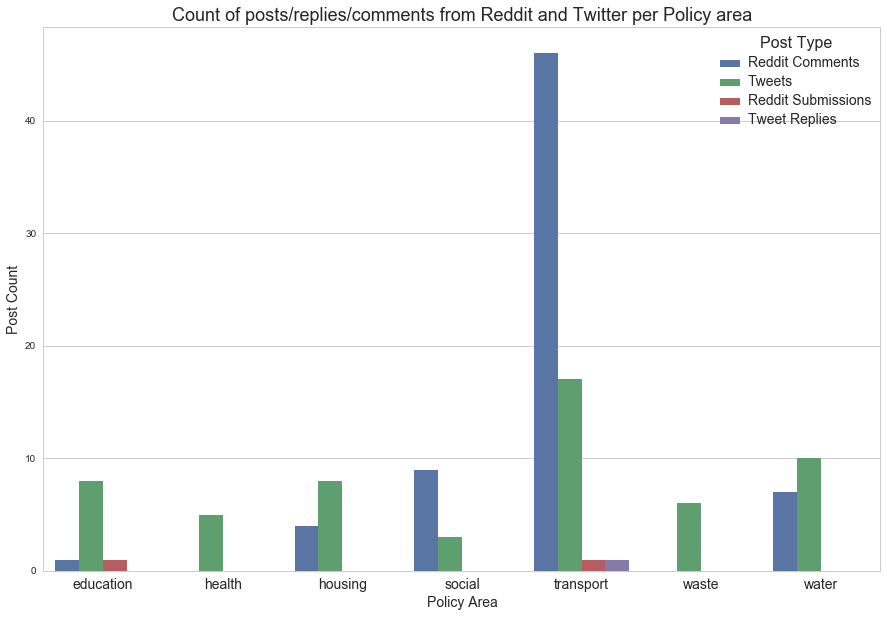

In [14]:
# Set figure size.
plt.figure(figsize=(15,10))

# Make bar plot of post counts per policy area.
bar = sns.barplot(data=dfRedditTwitter, x='Policy Area', y='Count', hue='Post Type')

bar.set_title('Count of posts/replies/comments from Reddit and Twitter per Policy area', fontsize='18')

# Set axes labels.
bar.set_xlabel("Policy Area",fontsize=14)
bar.set_ylabel("Post Count",fontsize=14)

plt.setp(bar.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(bar.get_legend().get_title(), fontsize='16') # for legend title

plt.setp(bar.get_xticklabels(), fontsize='14')

# Save the visualization.
fig = bar.get_figure()
fig.savefig("visualization_1_RedditTwitterPostCount.png")

### Visualize popularity of policies by Twitter favourites and retweets

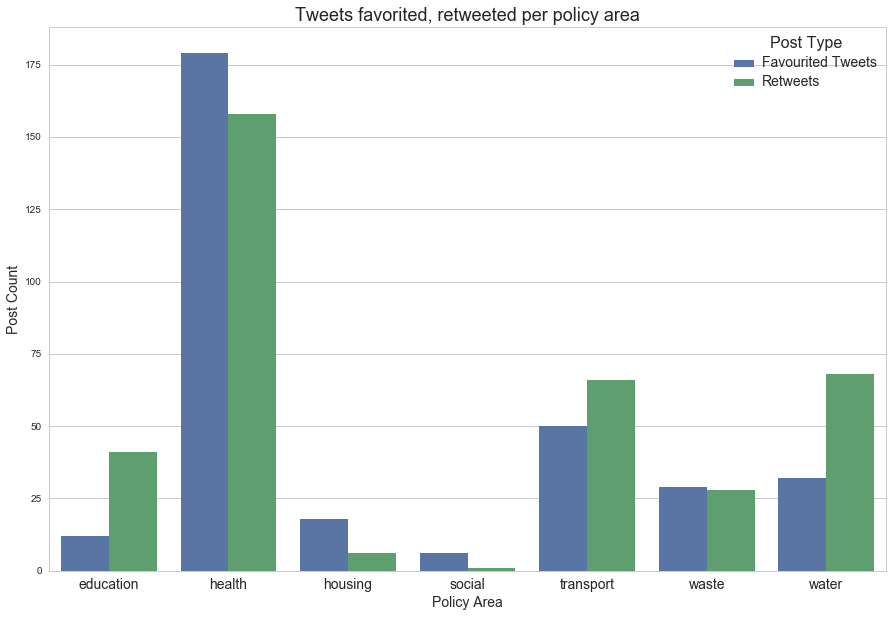

In [15]:
# Set figure size.
plt.figure(figsize=(15,10))

# Make bar plot of post counts per policy area.
bar = sns.barplot(data=dfFavRetweet, x='Policy Area', y='Count', hue='Post Type')

bar.set_title('Tweets favorited, retweeted per policy area', fontsize='18')

# Set axes labels.
bar.set_xlabel("Policy Area",fontsize=14)
bar.set_ylabel("Post Count",fontsize=14)

#Set font sizes.
plt.setp(bar.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(bar.get_legend().get_title(), fontsize='16') # for legend title
plt.setp(bar.get_xticklabels(), fontsize='14')

# Save the visualization.
fig = bar.get_figure()
fig.savefig("visualization_2_PolicyFavouritesRetweets.png")

### Visualize policy area wise sentiments reflected by Reddit and twitter posts (and comments)

In [16]:
# Arrange sentiments dataframe in format required to plot stacked bar plots
dfSent = pd.pivot_table(dfSentiments, index='Policy Area', 
               columns=['Post Type'], aggfunc=sum)
dfSent.columns = dfSent.columns.droplevel(0)
dfSent.columns = [col for col in dfSent.columns.values]
dfSent['Policy Area'] = dfSent.index
dfSent.reset_index(drop=True, inplace=True)

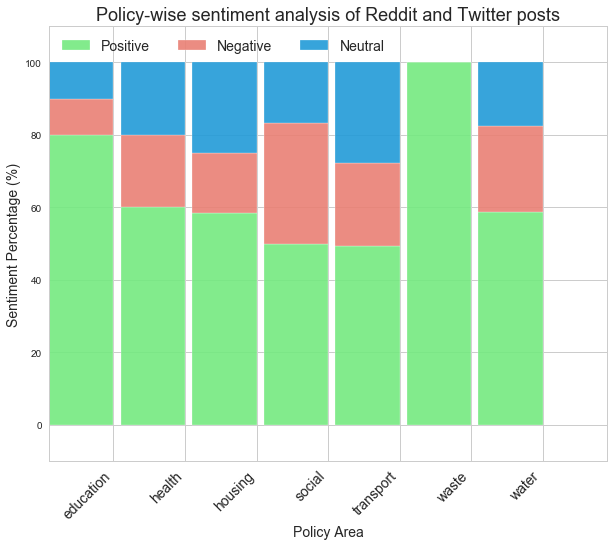

In [17]:
# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,8))

bar_width = 0.9
bar_l = [i for i in range(len(dfSent['Positive sentiments']))] 
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Calculate total of all sentiments
totals = [i+j+k for i,j,k in zip(dfSent['Positive sentiments'], 
                                 dfSent['Negative sentiments'], 
                                 dfSent['Neutral sentiments'])]

# Create the percentage of positive sentiments
pos_sent = [i / j * 100 for  i,j in zip(dfSent['Positive sentiments'], totals)]

# Create the percentage of negative sentiments
neg_sent = [i / j * 100 for  i,j in zip(dfSent['Negative sentiments'], totals)]

# Create the percentage of neutral sentiments
neu_sent = [i / j * 100 for  i,j in zip(dfSent['Neutral sentiments'], totals)]

# Bar chart for positive sentiments
ax.bar(bar_l, pos_sent, label='Positive', alpha=0.9,  color='#74e980',width=bar_width,edgecolor='white')

# Bar chart for negative sentiments
ax.bar(bar_l, neg_sent, bottom=pos_sent,label='Negative', alpha=0.9, color='#E98074', width=bar_width, edgecolor='white')

# Bar chart for neutral sentiments
ax.bar(bar_l, neu_sent, bottom=[i+j for i,j in zip(pos_sent, neg_sent)], label='Neutral', alpha=0.9, 
       color='#219AD8', width=bar_width, edgecolor='white')

# Set x axis to policy areas
plt.xticks(tick_pos, dfSent['Policy Area'])
ax.set_ylabel("Sentiment Percentage (%)", fontsize=14)
ax.set_xlabel("Policy Area", fontsize=14)
ax.legend(fontsize=14, loc='upper left', ncol=3)
ax.set_title('Policy-wise sentiment analysis of Reddit and Twitter posts', fontsize='18')

plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='14')

# Save the visualization.
plt.savefig("visualization_3_PolicySentimentAnalysis.png")
# shot plot
plt.show()


### Observations:   

1. A large number of tweets from Twitter and posts and comments from Reddit talk about transport-related policies. These posts include discussions in the last 6 months with keywords road, rail and bus.
2. Based on retweet and favourite counts, health-related policies appear to have generated a large amount of interest among the people.
3. From sentiment analysis, it appears that the response has been mostly positive from people. Tweets related to waste management especially show satisfaction on people’s end.
4. It appears that Reddit facilitates more discussions based on counts of comments as compared to Twitter, which is mostly used for announcements but doesn’t encourage discussions.    

<hr>